In [0]:
#!pip install surprise

     |████████████████████████████████| 6.5MB 2.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673667 sha256=09437660724f6a06416afcd6e2072632bd456fbd5b850125ecf1a7bdb0298ecc
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [0]:
# Many parts of this code are based on the content of: https://github.com/domkowald/LFM1b-analyses
# Please refer to it if using it. 
# Data available at: https://zenodo.org/record/3475975#.Xr1TYhNKgxh
# Note: both links above do not reveal the names of the authors of 
# this paper (submitted to ISMIR 2020)

# *Please change the data directories when using the code
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 15
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'artist'
top_fraction = 0.2
user_events_file = 'drive/My Drive/user_events.txt'
low_user_file = 'drive/My Drive/low_main_users.txt'
medium_user_file = 'drive/My Drive/medium_main_users.txt'
high_user_file = 'drive/My Drive/high_main_users.txt'

In [0]:
# read user events
cols = ['user', 'artist', 'album', 'track', 'timestamp']
df_events = pd.read_csv(user_events_file, sep='\t', names=cols, low_memory=False)
print('No. of user events: ' + str(len(df_events)))

No. of user events: 28718087


In [0]:
len(df_events['artist'].unique().tolist()) # 352805

352805

In [0]:
# create user-item matrix
df_events = df_events.groupby(['user', predict_col]).size().reset_index(name='count')
print('No. user-item interactions: ' + str(len(df_events)))

No. user-item interactions: 1755361


In [0]:
df_events = df_events[df_events['count'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user events: 1755361
No. filtered items: 352805


In [0]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 352805


In [0]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 70561


In [0]:
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [0]:
# get populairty fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
main_values = []
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        main_values.append(low_users.loc[u]['M_global_R_APC'])
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        main_values.append(medium_users.loc[u]['M_global_R_APC'])
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
       # main_values.append(high_users.loc[u]['M_global_R_APC'])
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print(low_count + med_count + high_count)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

3000
Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


In [0]:
# Popularity clusterisation with Gaussian Mixtures ---- 
pop = df_events.groupby(['user', 'artist']).first()
pop = pop.groupby(['artist']).count()
pop['prop'] = pop['count'] / len(df_events['user'].unique().tolist())

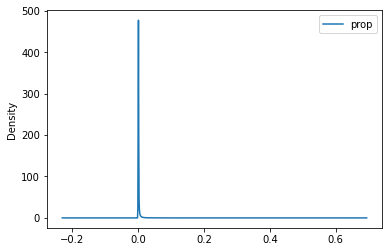

In [0]:
np.median(pop['prop'])
pop['prop'].plot(kind='density', legend=True)

In [0]:
pops = np.asarray(pop['prop']).reshape(-1, 1)
pops.max()

0.463

In [0]:
from sklearn.mixture import GaussianMixture
models = []

# trying different cluster numbers 
for i in range(2,10):
    model = GaussianMixture(n_components=i)
    model_fit = model.fit(pops)
    model_bic = model.bic(pops)
    models += [model_bic]

In [0]:
pos_bic = -np.asarray(models) 
pos_bic/10000 # highest change from 2 to 3

array([368.78019824, 374.63237294, 375.41247315, 375.53469135,
       375.64567853, 375.61434777, 375.89231668, 376.24644569])

In [0]:
model = GaussianMixture(n_components = 3)
model_fit = model.fit(pops)

# predicting clusters for the artists
predictions = model.predict(pops) 
d = {'data': pops[0:,0], 'pred': predictions[0:,]}
df = pd.DataFrame(data = d)
df['artists'] = df_events['artist'].unique()[0:, ]
group_df = df.groupby('pred')['data']

<Figure size 432x288 with 0 Axes>

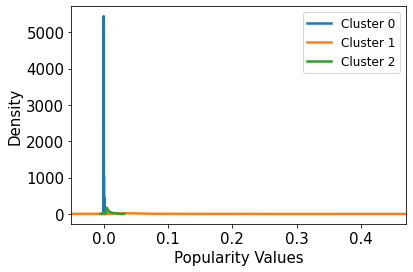

In [0]:
from cycler import cycler
plt.figure()
fig, ax = plt.subplots(1,1)
plt.rc('axes', prop_cycle=(cycler('color', ['#e19e57', '#3165b1', '#8eb155', '#B22222'])))
group_df.plot(kind = 'density', legend = True, linewidth = 2.5)
plt.yticks(fontsize='15')
plt.xticks(fontsize='15')
plt.ylabel('Density', fontsize='15')
plt.xlabel('Popularity Values', fontsize='15')
plt.xlim(-0.05, 0.47)
h,l = ax.get_legend_handles_labels()
ax.legend(h[:3],["Cluster 0", "Cluster 1", "Cluster 2"], loc = 0, fontsize = 12)
#plt.savefig('clusters.png', dpi=300, bbox_inches='tight')

In [0]:
counts_clusters = df.groupby('pred').size().to_frame('count')
probs = counts_clusters['count'] / df.shape[0]
probs # checking proportions of clusters
#----------------------------------------

pred
0    0.943122
1    0.010411
2    0.046468
Name: count, dtype: float64

In [0]:
# Data wrangling & scaling for the recommendation algorithms
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    min_rating = group['count'].min()
    max_rating = group['count'].max()
    scaler = MinMaxScaler(feature_range=(1, 1000))
    scaled_ratings = scaler.fit_transform(group['count'].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows['count'] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)


In [0]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0000000000001


In [0]:
reader = Reader(rating_scale=(df_events['count'].min(), df_events['count'].max()))

In [0]:
data = Dataset.load_from_df(df_events, reader)

In [0]:
trainset, testset = train_test_split(data, test_size = 0.2, random_state = my_seed)

In [0]:
def get_top_n(predictions, n=50):
    print('All: ')
    accuracy.mae(predictions)
    # First map the predictions to each user.
    top_n = defaultdict(list)
    low_mae = []
    med_mae = []
    high_mae = []
    all_mae = []
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        new = top_n[uid]
        df6 = pd.DataFrame(predictions)
        df6 = df6.loc[df6['uid'] == uid]
        df5 = pd.DataFrame(new, columns=['iid', 'rating'])
        tent = pd.merge(df6, df5[['iid']], on='iid', how='inner')
        prediction_new = tuple(map(tuple, np.array(tent)))
        # Caclulate MAE for each user
        if uid in low_users.index:
          low_mae.append(accuracy.mae(prediction_new, verbose=False))
        elif uid in medium_users.index:
          med_mae.append(accuracy.mae(prediction_new, verbose=False))
        elif uid in high_users.index:
          high_mae.append(accuracy.mae(prediction_new, verbose=False))
    
    all_mae = low_mae + med_mae + high_mae
   
    # Show average MAE considering all users
    print('All_top_n: ' + str(np.mean(all_mae)))
    print('LowMS: ' + str(np.mean(low_mae)))
    print('MedMS: ' + str(np.mean(med_mae)))
    print('HighMS: ' + str(np.mean(high_mae)))
    print(stats.ttest_ind(low_mae, high_mae))
    return top_n;

In [0]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [0]:
def get_top_n_modif(predictions, n=100, df = df):
  print('All: ')
  accuracy.mae(predictions)
  top_n = defaultdict(list)
  low_mae = []
  med_mae = []
  high_mae = []
  all_mae = []
  m = int(n * 0.5)
  
  # First map the predictions to each user.
  for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))
    
  # Then sort the predictions for each user and retrieve the k highest ones.
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True) 
    top_n[uid] = user_ratings[:n]
    filt = top_n[uid]
    new = list()
    for l in range(0, len(filt)):
      a = filt[l]
      b = df[df['artists'] == filt[l][0]].iat[0,1]
      new.append(a + (b,))
    df5 = pd.DataFrame(new, columns=['iid', 'rating', 'cluster'])
    # Sample from MU(m, theta)
    pred_sample = np.random.choice([0, 2, 1], size=(m,), p=[0.90, 0.07, 0.03])
    unique, counts = np.unique(pred_sample, return_counts=True)

    # Avoid having no artists from cluster 1 and 2
    if len(counts) == 1:
      counts = np.append(counts, [1, 1])
    if len(counts) == 2:
      counts = np.append(counts, 1)

    dd_0 = df5[df5['cluster']==0].sort_values(by='rating', ascending=False).head(n = counts[0])
    dd_1 = df5[df5['cluster']==1].sort_values(by='rating', ascending=False).head(n = counts[2])
    dd_2 = df5[df5['cluster']==2].sort_values(by='rating', ascending=False).head(n = counts[1])
    # This should now respect the clustering proportions
    conc = pd.concat([dd_0, dd_1, dd_2])
    arr = np.array(conc[["iid", "rating"]])
    top_n[uid] = tuple(map(tuple, arr))

    df6 = pd.DataFrame(predictions)
    df6 = df6.loc[df6['uid'] == uid]
    tent = pd.merge(df6, conc[['iid']], on='iid', how='inner')
    prediction_new = tuple(map(tuple, np.array(tent)))
    
    if uid in low_users.index:
      low_mae.append(accuracy.mae(prediction_new, verbose=False))
    elif uid in medium_users.index:
      med_mae.append(accuracy.mae(prediction_new, verbose=False))
    elif uid in high_users.index:
      high_mae.append(accuracy.mae(prediction_new, verbose=False))

   # Show average MAE considering all users
  all_mae = low_mae + med_mae + high_mae
  print('All_top_n: ' + str(np.mean(all_mae)))
  print('LowMS: ' + str(np.mean(low_mae)))
  print('MedMS: ' + str(np.mean(med_mae)))
  print('HighMS: ' + str(np.mean(high_mae)))
  print(stats.ttest_ind(low_mae, high_mae))
  return top_n;

In [0]:

sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [] # Random and MostPopular is calculated by default
algos.append(None)#Random())
algos.append(None)#MostPopular())
algos.append(BaselineOnly())
algos.append(KNNBasic(sim_options = sim_users, k=40)) 
algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
algos.append(NMF(n_factors = 15))
algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF']

# Not using Random and MostPopular in this case
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []
for i in range(2, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    algos[i].fit(trainset)
    predictions = algos[i].test(testset)
    print(algo_names[i])
    top_n = get_top_n(predictions, n = 28)

    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
        if uid in low_users.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in medium_users.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high_users.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

#Estimating biases using als...
#UserItemAvg
#All: 
#MAE:  38.7938
#All_top_n: 75.66206690079116
#LowMS: 73.2539356608222
#MedMS: 72.86293646349544
#HighMS: 80.86932857805584
#Ttest_indResult(statistic=-4.866361158105536, pvalue=1.225764608756361e-06)
#Computing the cosine similarity matrix...
#Done computing similarity matrix.
#UserKNN
#All: 
#MAE:  45.8192
#All_top_n: 89.998961973239
#LowMS: 87.79256386948127
#MedMS: 91.83381896522718
#HighMS: 90.3705030850086
#Ttest_indResult(statistic=-1.6895194477960314, pvalue=0.09127594116718961)
#Computing the cosine similarity matrix...
#Done computing similarity matrix.
#UserKNNAvg
#All: 
#MAE:  42.0518
#All_top_n: 83.87063723207527
#LowMS: 84.11266731404584
#MedMS: 81.52913525552461
#HighMS: 85.97010912665539
#Ttest_indResult(statistic=-1.1727228420834372, pvalue=0.24104676541166234)
#NMF
#All: 
#MAE:  35.0993
#All_top_n: 57.61015512609951
#LowMS: 55.60734174626834
#MedMS: 51.98839081300756
#HighMS: 65.23473281902261
#Ttest_indResult(statistic=-5.72105100003131, pvalue=1.2185193762764572e-08)

Estimating biases using als...
UserItemAvg
All: 
MAE:  38.7938
All_top_n: 75.66206690079116
LowMS: 73.2539356608222
MedMS: 72.86293646349544
HighMS: 80.86932857805584
Ttest_indResult(statistic=-4.866361158105536, pvalue=1.225764608756361e-06)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  45.8192
All_top_n: 89.998961973239
LowMS: 87.79256386948127
MedMS: 91.83381896522718
HighMS: 90.3705030850086
Ttest_indResult(statistic=-1.6895194477960314, pvalue=0.09127594116718961)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  42.0518
All_top_n: 83.87063723207527
LowMS: 84.11266731404584
MedMS: 81.52913525552461
HighMS: 85.97010912665539
Ttest_indResult(statistic=-1.1727228420834372, pvalue=0.24104676541166234)
NMF
All: 
MAE:  35.0993
All_top_n: 57.61015512609951
LowMS: 55.60734174626834
MedMS: 51.98839081300756
HighMS: 65.23473281902261
Ttest_indResult(statistic=-5.72105100003131, pvalue=1.218519

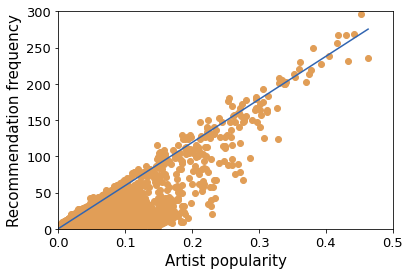

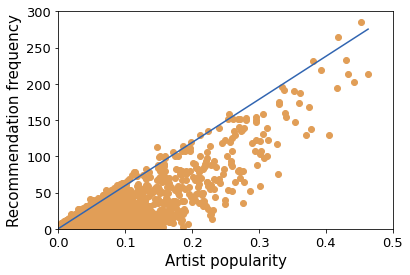

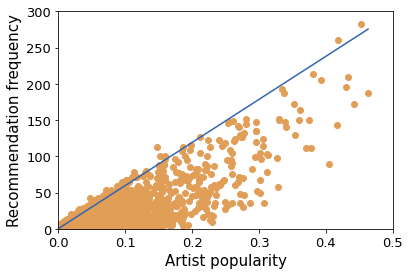

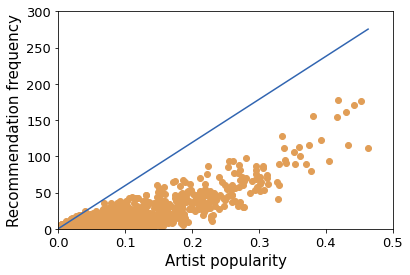

In [0]:
from cycler import cycler

# Plot results: frequencies x popularity 
for i in range(2, 6):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #line = slope * np.array(x) + intercept
    #print(r_value)
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        plt.gca().set_ylim(0, 300)

    line = 595 * np.array(x)     
    plt.rc('axes', prop_cycle=(cycler('color', ['#e19e57', '#3165b1', '#8eb155', '#B22222'])))
    plt.plot(x, y, 'o', x, line)
    plt.xlim(0, 0.5)
    plt.ylim(0, 300)
    plt.xlabel('Artist popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    #plt.savefig('drive/My Drive/sampl_28_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')

In [0]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, 4):
    low_gap_vals.append((low_rec_gap_list[i] - low_gap) / low_gap * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - medium_gap) / medium_gap * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_gap) / high_gap * 100)

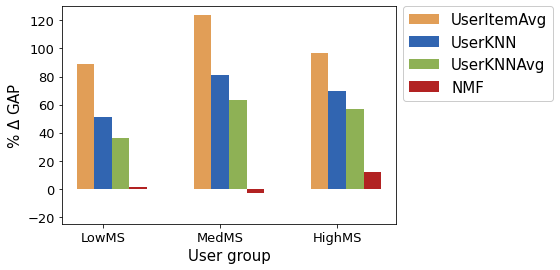

In [0]:
barWidth = 0.15

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='UserItemAvg')
plt.bar(r2, bars2, width=barWidth, label='UserKNN')
plt.bar(r3, bars3, width=barWidth, label='UserKNNAvg')
plt.bar(r4, bars4, width=barWidth, label='NMF')

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='15')
plt.rc('axes', prop_cycle=(cycler('color', ['#e19e57', '#3165b1', '#8eb155', '#B22222'])))
plt.ylabel('% $\Delta$ GAP', fontsize='15')
plt.gca().set_ylim(-25, 130)
plt.xticks([r + barWidth for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='13')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='15')
plt.savefig('drive/My Drive/gap_analysis_28.png', dpi=300, bbox_inches='tight')

In [0]:
# Now we do the same for the adapted method
low_rec_gap_list_modif = [] # one entry per algorithmus
medium_rec_gap_list_modif = []
high_rec_gap_list_modif = []

i = 2

low_rec_gap = 0
medium_rec_gap = 0
high_rec_gap = 0
    
algos[i].fit(trainset)
predictions = algos[i].test(testset)
print(algo_names[i])
top_n = get_top_n_modif(predictions, n=60)
low_count = 0
med_count = 0
high_count = 0
for uid, user_ratings in top_n.items():
    iid_list = []
    for (iid, _) in user_ratings:
        df_item_dist_modif.loc[iid, algo_names[i]] += 1
        iid_list.append(iid)
    gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
    print(iid)
    if uid in low_users.index:
        low_rec_gap += gap
        low_count += 1
    elif uid in medium_users.index:
        medium_rec_gap += gap
        med_count += 1
    elif uid in high_users.index:
        high_rec_gap += gap
        high_count += 1
low_rec_gap_list_modif.append(low_rec_gap / low_count)
medium_rec_gap_list_modif.append(medium_rec_gap / med_count)
high_rec_gap_list_modif.append(high_rec_gap / high_count)

# Estimating biases using als...
# UserItemAvg
# All: 
# MAE:  38.7938
# All_top_n: 65.62560106338888
# LowMS: 66.46755578889541
# MedMS: 61.8824250816854
# HighMS: 68.52682231958586
# Ttest_indResult(statistic=-1.3236163877978404, pvalue=0.18578190531962074)

Estimating biases using als...
UserItemAvg
All: 
MAE:  38.7938
All_top_n: 65.62560106338888
LowMS: 66.46755578889541
MedMS: 61.8824250816854
HighMS: 68.52682231958586
Ttest_indResult(statistic=-1.3236163877978404, pvalue=0.18578190531962074)
15154.0
99.0
39056.0
32.0
6852.0
21526.0
229.0
1969.0
4115.0
301.0
4482.0
6872.0
73262.0
249.0
2230.0
3019.0
301.0
301.0
406.0
157062.0
4193.0
3263.0
19.0
7256.0
14806.0
289.0
47.0
8649.0
27720.0
301.0
368.0
289.0
99.0
32559.0
4117.0
10566.0
2487.0
44199.0
368.0
8007.0
7492.0
368.0
17434.0
3019.0
10324.0
4227.0
2988.0
689.0
2683.0
79.0
15370.0
1807.0
272.0
4115.0
368.0
43.0
301.0
14427.0
8890.0
14783.0
368.0
8039.0
2266.0
406.0
4115.0
2573.0
289.0
4300.0
71.0
368.0
3387.0
7492.0
27720.0
16277.0
3915.0
9637.0
8996.0
2837.0
93064.0
14806.0
1326.0
18028.0
10265.0
406.0
229.0
2993.0
15543.0
32.0
3138.0
32.0
16574.0
3318.0
1415.0
10330.0
145.0
71.0
47710.0
13825.0
3416.0
5174.0
3875.0
46.0
13187.0
1871.0
5397.0
368.0
249.0
46.0
7040.0
289.0
3670.0
32.0


In [0]:
i = 3
low_rec_gap = 0
medium_rec_gap = 0
high_rec_gap = 0
    
algos[i].fit(trainset)
predictions = algos[i].test(testset)
print(algo_names[i])
top_n = get_top_n_modif(predictions, n=60)
low_count = 0
med_count = 0
high_count = 0
for uid, user_ratings in top_n.items():
    iid_list = []
    for (iid, _) in user_ratings:
        df_item_dist_modif.loc[iid, algo_names[i]] += 1
        iid_list.append(iid)
    gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
    print(iid)
    if uid in low_users.index:
        low_rec_gap += gap
        low_count += 1
    elif uid in medium_users.index:
        medium_rec_gap += gap
        med_count += 1
    elif uid in high_users.index:
        high_rec_gap += gap
        high_count += 1
low_rec_gap_list_modif.append(low_rec_gap / low_count)
medium_rec_gap_list_modif.append(medium_rec_gap / med_count)
high_rec_gap_list_modif.append(high_rec_gap / high_count)

# Computing the cosine similarity matrix...
# Done computing similarity matrix.
# UserKNN
# All: 
# MAE:  45.8192
# All_top_n: 77.39904562296931
# LowMS: 79.35935969239543
# MedMS: 77.84739472986382
# HighMS: 74.99038244664867
# Ttest_indResult(statistic=3.0007226432419603, pvalue=0.002726729205413259)

Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  45.8192
All_top_n: 77.39904562296931
LowMS: 79.35935969239543
MedMS: 77.84739472986382
HighMS: 74.99038244664867
Ttest_indResult(statistic=3.0007226432419603, pvalue=0.002726729205413259)
54221.0
135.0
29069.0
2425.0
6852.0
21526.0
526.0
8890.0
4115.0
1535.0
99.0
194.0
301.0
7102.0
10330.0
368.0
2954.0
2990.0
406.0
157062.0
4115.0
1894.0
196285.0
100733.0
6872.0
1969.0
212.0
24347.0
27720.0
3954.0
5778.0
16293.0
99.0
26725.0
107037.0
2799.0
2941.0
44199.0
4115.0
405.0
13715.0
4482.0
29069.0
16277.0
4556.0
249.0
272.0
4317.0
2762.0
689.0
6872.0
1807.0
2123.0
2768.0
5162.0
1894.0
4118.0
3424.0
1359.0
32074.0
3019.0
8890.0
2487.0
13187.0
99.0
65256.0
99.0
6872.0
4482.0
1092.0
3387.0
6852.0
27720.0
16277.0
6852.0
391.0
314.0
39056.0
99.0
14806.0
1326.0
4117.0
4227.0
135.0
289.0
2993.0
3846.0
1325.0
17127.0
32.0
80459.0
3318.0
4533.0
122559.0
1998.0
122598.0
47710.0
3887.0
202058.0
249.0
3875.0
9

In [0]:
i = 4
low_rec_gap = 0
medium_rec_gap = 0
high_rec_gap = 0
    
algos[i].fit(trainset)
predictions = algos[i].test(testset)
print(algo_names[i])
top_n = get_top_n_modif(predictions, n=60)
low_count = 0
med_count = 0
high_count = 0
for uid, user_ratings in top_n.items():
    iid_list = []
    for (iid, _) in user_ratings:
        df_item_dist_modif.loc[iid, algo_names[i]] += 1
        iid_list.append(iid)
    gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
    print(iid)
    if uid in low_users.index:
        low_rec_gap += gap
        low_count += 1
    elif uid in medium_users.index:
        medium_rec_gap += gap
        med_count += 1
    elif uid in high_users.index:
        high_rec_gap += gap
        high_count += 1
low_rec_gap_list_modif.append(low_rec_gap / low_count)
medium_rec_gap_list_modif.append(medium_rec_gap / med_count)
high_rec_gap_list_modif.append(high_rec_gap / high_count)

# Computing the cosine similarity matrix...
# Done computing similarity matrix.
# UserKNNAvg
# All: 
# MAE:  42.0518
# All_top_n: 73.32289846405742
# LowMS: 76.55550296763501
# MedMS: 70.2167974681562
# HighMS: 73.19639495638106
# Ttest_indResult(statistic=2.139511256103164, pvalue=0.032515131438118454)

Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  42.0518
All_top_n: 73.32289846405742
LowMS: 76.55550296763501
MedMS: 70.2167974681562
HighMS: 73.19639495638106
Ttest_indResult(statistic=2.139511256103164, pvalue=0.032515131438118454)
15154.0
100572.0
39056.0
1894.0
6852.0
21526.0
526.0
13457.0
368.0
69.0
4482.0
194.0
53467.0
5397.0
10330.0
368.0
301.0
2990.0
1359.0
16797.0
4115.0
15494.0
4206.0
100733.0
6872.0
289.0
23912.0
8649.0
27720.0
21931.0
34.0
14783.0
32.0
24865.0
4117.0
48645.0
39734.0
99.0
39037.0
405.0
2487.0
368.0
29069.0
3019.0
4556.0
249.0
2920.0
9916.0
2762.0
2352.0
36731.0
1807.0
2123.0
2768.0
192.0
16654.0
10705.0
3424.0
8890.0
32074.0
3019.0
8890.0
4035.0
32912.0
99.0
65256.0
99.0
6872.0
4482.0
248.0
3387.0
6852.0
27720.0
8047.0
3915.0
4467.0
8996.0
39056.0
99.0
43.0
1326.0
18028.0
4227.0
2266.0
289.0
2993.0
3846.0
32.0
17127.0
30154.0
65595.0
3318.0
8316.0
122559.0
1998.0
122598.0
121943.0
13825.0
15154.0
5174.0
5311

In [0]:
i = 5
low_rec_gap = 0
medium_rec_gap = 0
high_rec_gap = 0
    
algos[i].fit(trainset)
predictions = algos[i].test(testset)
print(algo_names[i])
top_n = get_top_n_modif(predictions, n=60)
low_count = 0
med_count = 0
high_count = 0
for uid, user_ratings in top_n.items():
    iid_list = []
    for (iid, _) in user_ratings:
        df_item_dist_modif.loc[iid, algo_names[i]] += 1
        iid_list.append(iid)
    gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
    print(iid)
    if uid in low_users.index:
        low_rec_gap += gap
        low_count += 1
    elif uid in medium_users.index:
        medium_rec_gap += gap
        med_count += 1
    elif uid in high_users.index:
        high_rec_gap += gap
        high_count += 1
low_rec_gap_list_modif.append(low_rec_gap / low_count)
medium_rec_gap_list_modif.append(medium_rec_gap / med_count)
high_rec_gap_list_modif.append(high_rec_gap / high_count)

# NMF
# All: 
# MAE:  35.1340
# All_top_n: 53.2076861472533
# LowMS: 55.736567272574256
# MedMS: 47.34880675009816
# HighMS: 56.53768441908747
# Ttest_indResult(statistic=-0.47879929627575063, pvalue=0.6321338092662392)

NMF
All: 
MAE:  35.1340
All_top_n: 53.2076861472533
LowMS: 55.736567272574256
MedMS: 47.34880675009816
HighMS: 56.53768441908747
Ttest_indResult(statistic=-0.47879929627575063, pvalue=0.6321338092662392)
13187.0
100572.0
39056.0
1823325.0
2801.0
5821.0
17542.0
8197.0
368.0
501245.0
99.0
80363.0
7989.0
5397.0
5411.0
6138.0
3078.0
2487.0
39779.0
1894.0
39311.0
15494.0
86451.0
100733.0
13074.0
29945.0
22932.0
2881979.0
9334.0
301.0
34.0
121893.0
99.0
823879.0
107037.0
48645.0
29628.0
12403.0
368.0
5504.0
7492.0
4117.0
39311.0
2878.0
52130.0
282140.0
28261.0
27857.0
17817.0
79.0
36731.0
11925.0
30787.0
4115.0
140138.0
63825.0
550758.0
6861.0
432.0
430278.0
14783.0
6320.0
9952.0
10763.0
4115.0
2060689.0
28818.0
4300.0
40102.0
2487.0
3318.0
7492.0
46.0
43781.0
16579.0
4467.0
8996.0
15095.0
65244.0
32.0
27720.0
4117.0
100929.0
35914.0
16269.0
2993.0
1813808.0
58899.0
3138.0
28208.0
15578.0
2827.0
8926.0
10330.0
3050.0
2266.0
121503.0
13825.0
3416.0
15623.0
9861.0
46.0
13187.0
20000.0
2768.0
4

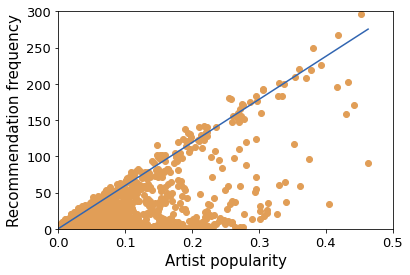

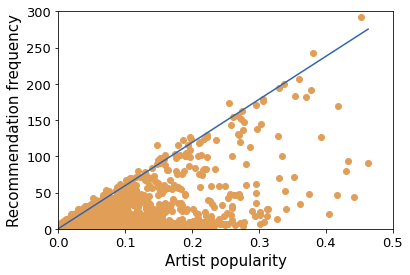

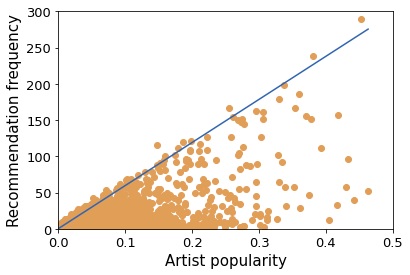

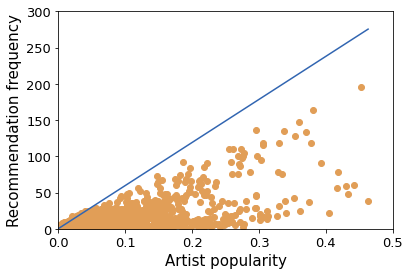

In [0]:
from cycler import cycler
# Plot results: recommendation frequency x popularity 
for i in range(2, 6):
    plt.figure()
    x = df_item_dist_modif['count']
    y = df_item_dist_modif[algo_names[i]]
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #line = slope * np.array(x) + intercept
    #print(r_value)
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        plt.gca().set_ylim(0, 300)

    line = 595 * np.array(x)     
    plt.rc('axes', prop_cycle=(cycler('color', ['#e19e57', '#3165b1', '#8eb155', '#B22222'])))
    plt.plot(x, y, 'o', x, line)
    plt.xlim(0, 0.5)
    plt.ylim(0, 300)
    plt.xlabel('Artist popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    #plt.savefig('drive/My Drive/sampl_modif_2_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')

In [0]:
low_gap_vals_modif = []
medium_gap_vals_modif = []
high_gap_vals_modif = []

for i in range(0, 4):
    low_gap_vals_modif.append((low_rec_gap_list_modif[i] - low_gap) / low_gap * 100)
    medium_gap_vals_modif.append((medium_rec_gap_list_modif[i] - medium_gap) / medium_gap * 100)
    high_gap_vals_modif.append((high_rec_gap_list_modif[i] - high_gap) / high_gap * 100)


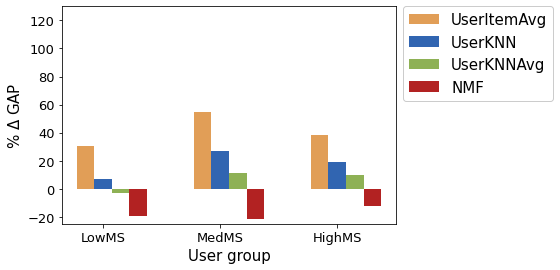

In [0]:
barWidth = 0.15

# set height of bar
bars1 = [low_gap_vals_modif[0], medium_gap_vals_modif[0], high_gap_vals_modif[0]]
bars2 = [low_gap_vals_modif[1], medium_gap_vals_modif[1], high_gap_vals_modif[1]]
bars3 = [low_gap_vals_modif[2], medium_gap_vals_modif[2], high_gap_vals_modif[2]]
bars4 = [low_gap_vals_modif[3], medium_gap_vals_modif[3], high_gap_vals_modif[3]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='UserItemAvg')
plt.bar(r2, bars2, width=barWidth, label='UserKNN')
plt.bar(r3, bars3, width=barWidth, label='UserKNNAvg')
plt.bar(r4, bars4, width=barWidth, label='NMF')

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='15')
plt.ylabel('% $\Delta$ GAP', fontsize='15')
plt.gca().set_ylim(-25, 130)
plt.xticks([r + barWidth for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='13')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='15')
#plt.savefig('drive/My Drive/gap_analysis_modif_22.png', dpi=300, bbox_inches='tight')